# Import Library 

In [2]:
# for data
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
!pip install lime
# for explainer
from lime import lime_tabular




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 275 kB 4.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=29ab73a0bffdb206dc3e58bbd128d61ba44f9665d5391183f417dda235108862
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# Open "train.csv" file for demo

---

In [33]:
dtf = pd.read_csv('train.csv') 
dtf.head() # Display DataFrame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,NaN,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Define Columns Whether be Categories or Number Type

---



In [34]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype is object) | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

# Testing
print(utils_recognize_type(dtf, "Parch"))
print(utils_recognize_type(dtf, "Age"))
print(utils_recognize_type(dtf, "Survived"))

cat
num
cat


# Show missing-value Chart

---



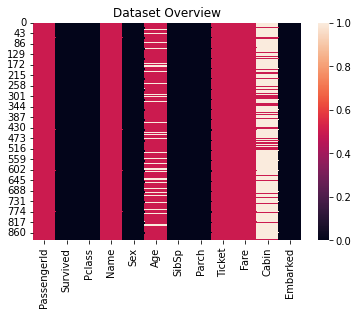

 Categerocial   Numeric   NaN 


In [35]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull() # isnull DataFrame
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1) # 'num' columns
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1) # 'cat' columns
sns.heatmap(heatmap, cbar=True).set_title('Dataset Overview') # Create heatmap
plt.show() # Show heatmap
# Print colorized ouput onto terminal
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

# Setup columns 

---

In [29]:
dtf = dtf.set_index("PassengerId") # Set index for "PassengerId"
dtf = dtf.rename(columns={"Survived":"Y"}) # Rename column "Survived" to "Y"

# Bar Plot (Y Column)

---


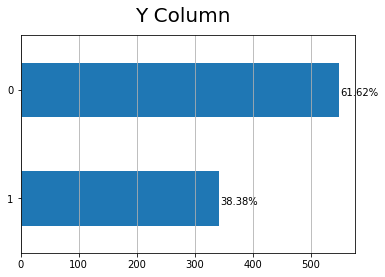

In [ ]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals) # Sum all rectangle's width
for i in ax.patches:
     ax.text(i.get_width()+ 1, i.get_y()+.20, # Alignment for text's display
     str(round((i.get_width()/total)*100, 2))+'%', # Calculate proportion and get 2-digit precision
     fontsize=10, color='black') # Style for text's display
ax.grid(axis="x") # Add grid line
plt.suptitle(y + " Column", fontsize=20)
plt.show()

# Box plot (Age Column)

---

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


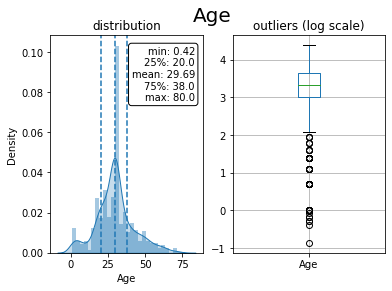

In [27]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution plot
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean()) # Fill null value in DataFrame with average number (mean()) of that column
breaks = np.quantile(variable, q=np.linspace(0, 1, 11)) # Define quantiles with 10 even parts
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ] # Make sure variable is in range of calculated quantile
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe() # Include statistics's info
# Add broken lines
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True) # Enable ruler (gridline)
des = round(des, 2).apply(lambda x: str(x)) # Round each values in Series with 2-digit precision and convert to string

### Create a box of statistics 's info
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()